In [1]:
!git lfs install
!git clone https://huggingface.co/datasets/RUCAIBox/Style-Transfer
!mv Style-Transfer/gyafc_em.tgz .
!mv Style-Transfer/gyafc_fr.tgz .
!tar -zxf gyafc_em.tgz
!tar -zxf gyafc_fr.tgz

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into 'Style-Transfer'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11
Unpacking objects: 100% (11/11), 1.62 KiB | 554.00 KiB/s, done.
Filtering content: 100% (2/2), 5.02 MiB | 2.29 MiB/s, done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install transformers pyemd transformers_interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.8/793.8 KB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.8 MB/s eta 0:00:00
  Attempting uninstall: ipython
    Found existing installation: ipython 7.9.0
    Uninstalling ipython-7.9.0:
      Successfully uninstalled ipython-7.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab

In [4]:
import ast
import time
from typing import List
import torch
import numpy as np
import pandas as pd
from pyemd import emd
from transformers_interpret import SequenceClassificationExplainer
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
)
import pandas as pd
from sklearn.metrics import accuracy_score
import json

In [4]:


class StyleIntensityClassifier:
    """
    Utility for calculating Style Transfer Intensity between
    two pieces of text (i.e. input and output of TST model)
    This custom evaluation metric aims to quantify the magnitude of transfered
    style between two texts. To accomplish this, we pass input and output texts
    through a trained style classifier to produce two distributions. We then
    utilize Earth Movers Distance (EMD) to calculate the minimum "cost"/"work"
    required to turn the input distribution into the output distribution. This
    metric allows us to capture a more nuanced, per-example measure of style
    transfer when compared to simply applying a classifier to determine the
    binary decision of achieved target style? (yes/no).
    Attributes:
        model_identifier (str)
    """

    def __init__(self, model_identifier: str):
        self.model_identifier = model_identifier
        self.device = (
            torch.cuda.current_device() if torch.cuda.is_available() else "cpu"
        )
        self._build_pipeline()

    def _build_pipeline(self):

        self.pipeline = pipeline(
            task="text-classification",
            model=self.model_identifier,
            device=self.device,
            return_all_scores=True,
        )

    def score(self, input_text: List[str]):
        """
        Classify a given input text as subjective or neutral using
        model initialized by the class.
        Args:
            input_text (`str` or `List[str]`) - Input text for classification
        Returns:
            classification (dict) - a dictionary containing the label, score, and
                distribution between classes
        """
        result = self.pipeline(input_text)
        distributions = np.array(
            [[label["score"] for label in item] for item in result]
        )
        return [
            {
                "label": self.pipeline.model.config.id2label[scores.argmax()],
                "score": scores.max(),
                "distribution": scores.tolist(),
            }
            for scores in distributions
        ]

    def calculate_transfer_intensity(
        self, input_text: List[str], output_text: List[str], target_class_idx: int = 1
    ) -> List[float]:
        """
        Calcualates the style transfer intensity (STI) between two pieces of text.
        Args:
            input_text (list) - list of input texts with indicies corresponding
                to counterpart in output_text
            ouptput_text (list) - list of output texts with indicies corresponding
                to counterpart in input_text
            target_class_idx (int) - index of the target style class used for directional
                score correction
        Returns:
            A list of floats with corresponding style transfer intensity scores.
        """

        if len(input_text) != len(output_text):
            raise ValueError(
                "input_text and output_text must be of same length with corresponding items"
            )

        input_dist = [item["distribution"] for item in self.score(input_text)]
        output_dist = [item["distribution"] for item in self.score(output_text)]

        return [
            self.calculate_emd(input_dist[i], output_dist[i], target_class_idx)
            for i in range(len(input_dist))
        ]

    @staticmethod
    def calculate_emd(input_dist, output_dist, target_class_idx):
        """
        Calculate the direction-corrected Earth Mover's Distance (aka Wasserstein distance)
        between two distributions of equal length. Here we penalize the EMD score if
        the output text style moved further away from the target style.
        Reference: https://github.com/passeul/style-transfer-model-evaluation/blob/master/code/style_transfer_intensity.py
        Args:
            input_dist (list) - probabilities assigned to the style classes
                from the input text to style transfer model
            output_dist (list) - probabilities assigned to the style classes
                from the outut text of the style transfer model
        Returns:
            emd (float) - Earth Movers Distance between the two distributions
        """

        N = len(input_dist)
        distance_matrix = np.ones((N, N))
        dist = emd(np.array(input_dist), np.array(output_dist), distance_matrix)

        transfer_direction_correction = (
            1 if output_dist[target_class_idx] >= input_dist[target_class_idx] else -1
        )

        return round(dist * transfer_direction_correction, 4)


def STIEvaluator(ste, input_corpus, generate_corpus):
    return ste.calculate_transfer_intensity(
        input_text=input_corpus, output_text=generate_corpus
    )




In [5]:
with open("sti_generation.txt") as f:
    inp = [line.strip() for line in f]

inp = ast.literal_eval(inp[0])
len(inp)

1416

In [7]:
import json
with open('sti_generation.txt', 'r') as f:
    inp = [line.strip() for line in f]

inp = ast.literal_eval(inp[0])
pred_scores=[]
for i in inp:
  pred_scores.append(i[0])

with open('sti_gyafc_em_test.txt', 'r') as f:
    inp = [line.strip() for line in f]

inp = ast.literal_eval(inp[0])
scores=[]
for i in inp:
  scores.append(i[0])

with open('gyafc_em/test.src', 'r') as f:
    src = [line.strip() for line in f]

with open('gyafc_em/test.tgt', 'r') as f:
    tgt = [line.strip() for line in f]

with open('generation_em.txt', 'r') as f:
    gen = [line.strip() for line in f]
print(len(src))
print(len(tgt))
print(len(gen))
print(len(pred_scores))
print(len(scores))

1416
1416
1416
1416
1416


In [8]:
df = pd.DataFrame({'source_text': src, 'target_text':tgt, 'pred_text': gen, 'pred_sti': pred_scores,'target_sti': scores})

df.head()

,source_text,target_text,pred_text,pred_sti,target_sti
0,Is Any Baby Really A Freak.,"['Is any baby really a freak.', 'Is any baby r...",Is any baby really a Freak?,0.0072,0.0000
1,"aspen colorado has he best music festivals, yo...","['Aspen Colorado has he best music festivals, ...",Aspen Colorado has one of the best music festi...,0.9919,0.0178
2,You can get almost anything on ebay!,"['You can get almost anything on ebay!', 'You ...",You can get almost anything on eBay!,0.0000,0.0000
3,everybody is Dying to get in,"['everybody is dying to get in.', 'Everyone is...",Everyone is dying to get in.,0.8963,0.9028
4,not idiots like 50 cent and his whole Gay unit...,"[""I'm not referring to people like 50 cent and...",Not idiots like 50 Cent and his entire Gay uni...,0.9746,0.9846


In [9]:
import json
with open('sti_generation_fr.txt', 'r') as f:
    inp = [line.strip() for line in f]

inp = ast.literal_eval(inp[0])
pred_scores=[]
for i in inp:
  pred_scores.append(i[0])

with open('sti_gyafc_fr_test.txt', 'r') as f:
    inp = [line.strip() for line in f]

inp = ast.literal_eval(inp[0])
scores=[]
for i in inp:
  scores.append(i[0])

with open('gyafc_fr/test.src', 'r') as f:
    src = [line.strip() for line in f]

with open('gyafc_fr/test.tgt', 'r') as f:
    tgt = [line.strip() for line in f]

with open('generation_fr.txt', 'r') as f:
    gen = [line.strip() for line in f]
print(len(src))
print(len(tgt))
print(len(gen))
print(len(pred_scores))
print(len(scores))

1332
1332
1332
1332
1332


In [10]:
df_fr = pd.DataFrame({'source_text': src, 'target_text':tgt, 'pred_text': gen, 'pred_sti': pred_scores,'target_sti': scores})
df_fr.head()

,source_text,target_text,pred_text,pred_sti,target_sti
0,And so what if it is a rebound relationship fo...,['What if it is a rebound relationship for bot...,What if it is a rebound relationship for both ...,0.9082,0.9082
1,Good luck in your search for the one!,['Good luck in your search for your perfect ma...,Good luck in your search for the one!,0.0000,0.0066
2,WHY DOES EVERYONE SEEM TO WANT SOMEONE THAT TH...,['Why does everyone seem to want someone that ...,Why does everyone seem to want someone that th...,0.0769,0.0802
3,Do you like to argue and fight???,"['Do you like to argue and fight?', 'Do you li...",Do you like to argue and fight?,0.9026,0.9026
4,"So if you're set on that, that's the way to go!!","['If you are set on that, that is the way to g...","If you are set on that, that is the way to go!",0.9764,0.9885


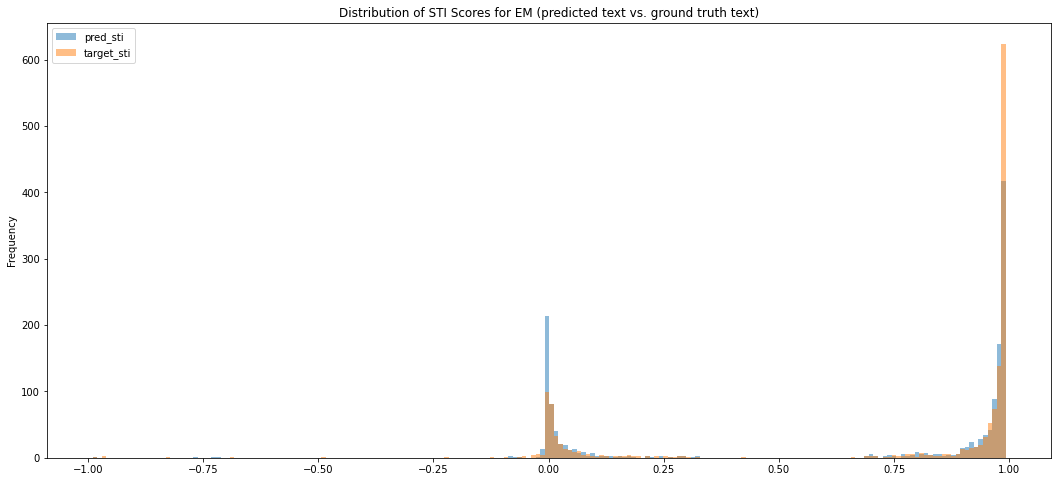

In [17]:
df[["pred_sti", "target_sti"]].plot(
    kind="hist",
    bins=200,
    alpha=0.5,
    figsize=(18, 8),
    title="Distribution of STI Scores for EM (predicted text vs. ground truth text)",
)

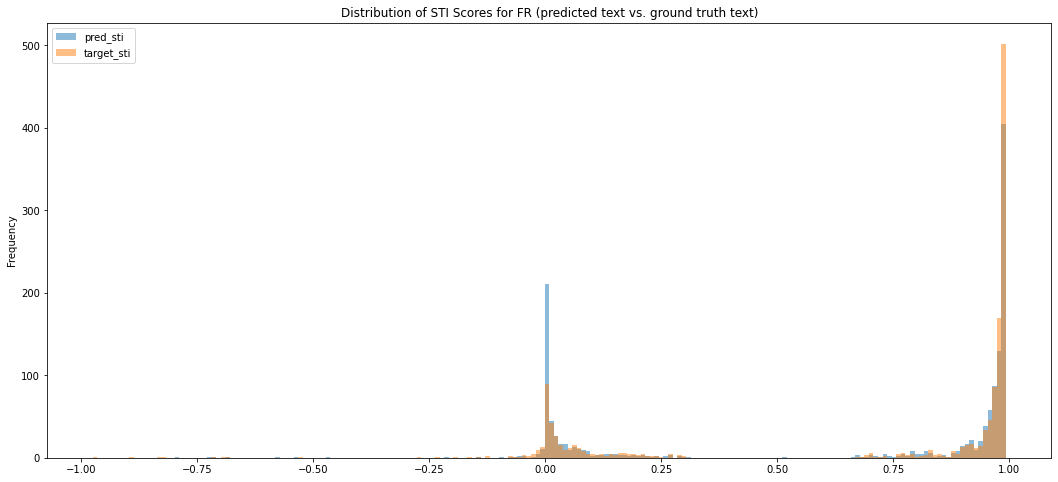

In [19]:
df_fr[["pred_sti", "target_sti"]].plot(
    kind="hist",
    bins=200,
    alpha=0.5,
    figsize=(18, 8),
    title="Distribution of STI Scores for FR (predicted text vs. ground truth text)",
)

In [20]:
def print_text_triplet(metric_df):

    for i, row in metric_df.iterrows():
        print(f"Pred STI: {row.pred_sti}")
        print(f"Target STI: {row.target_sti}")
        print(f"SOURCE_TEXT: {row.source_text}")
        print(f"TARGET_TEXT: {row.target_text}")
        print(f"PREDIC_TEXT: {row.pred_text}")
        print("----------------------------------------------------")
        print()
print_text_triplet(
    df[df.target_sti > 0.9].sort_values(
        "target_sti", ascending=False
    )[:50]
)

Pred STI: 0.9924
Target STI: 0.9925
SOURCE_TEXT: I don't really want answers with.. oh thats sweet just follow your dreams ors omething you know
TARGET_TEXT: ['I do not really want answers that say "Oh, that is sweet, just follow your dreams" or something similar; Do you understand what I mean?', 'I do not want answers that do not actually have advice.', 'I do not really want to hear answers such as: "Oh, that is sweet. Just follow your dreams," or something similar.', 'I do not want to answer with, oh, that is sweet, follow your dreams or something akin to that.']
PREDIC_TEXT: I do not really want answers, but that is sweet. Just follow your dreams or whatever you know.
----------------------------------------------------

Pred STI: 0.9917
Target STI: 0.9925
SOURCE_TEXT: depends....usully they are about ur personailty but not wat ur gonna do iwith ur life.
TARGET_TEXT: ["It's usually regarding your personality, not your life in the future.", 'They are generally about your personality,

In [17]:
print_text_triplet(df[df.pred_sti == 0][:5])

Pred STI: 0.0
Target STI: 0.0
SOURCE_TEXT: You can get almost anything on ebay!
TARGET_TEXT: ['You can get almost anything on ebay!', 'You can get almost anything on eBay.', 'You can purchase almost anything you want on Ebay!', 'You can buy almost anything on Ebay.']
PREDIC_TEXT: You can get almost anything on eBay!
----------------------------------------------------

Pred STI: 0.0
Target STI: 0.0049
SOURCE_TEXT: 50 is just riding coattails with that movie.
TARGET_TEXT: ['50 is just riding coattails with that move.', '50 is riding the coattails with that movie.', "I think he is just riding others' coattails with that movie.", 'He is not good in that movie.']
PREDIC_TEXT: 50 is just riding coattails with that movie.
----------------------------------------------------

Pred STI: 0.0
Target STI: 0.0
SOURCE_TEXT: The blind klan guy is hilarious!
TARGET_TEXT: ['The blind Klan guy is hilarious!', 'The guy in Blind Klan is hilarious.', 'The blind Klansman is very funny.', 'That person in hi

In [ ]:
#calculate sti_delta
df["sti_delta"] = df["target_sti"] - df["pred_sti"]

# target_sti >> pred_sti
print_text_triplet(df.sort_values(by="sti_delta", ascending=False).head(5))

In [ ]:
# target_sti << pred_sti
print_text_triplet(df.sort_values(by="sti_delta", ascending=False).tail(5))